In [1]:
# Load librarues
from google.colab import drive
import os
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Install extra libraries
! pip install transformers

     |████████████████████████████████| 2.6 MB 8.7 MB/s 
     |████████████████████████████████| 3.3 MB 50.1 MB/s 
     |████████████████████████████████| 895 kB 69.5 MB/s 
     |████████████████████████████████| 636 kB 92.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Set Project

In [3]:
# Mount external disc
mount_folder = os.path.join('/content', 'drive')
drive.mount(mount_folder)

Mounted at /content/drive


In [4]:
# Move to project path
project_path = os.path.join(mount_folder,'MyDrive','projects','product-absa')
os.chdir(project_path) 

In [5]:
# Import local library
from src.models.sentiment_analysis_polarity_classification.model_mgr import SentimentAnalysisPolarityClassifierMgr

# Set analysis functions

In [6]:
# Define analysis functions

def auc_analysis(probs, label_mgr, target_names, y_true):
  auc_analysis = {}
  for positive_class in target_names:
    positive_class = positive_class  # 'positive'
    positive_index = label_mgr.label_name_map[positive_class]
    positive_probs = [prob[positive_index] for prob in probs.tolist()]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=positive_probs, pos_label=positive_class)
    roc_auc = auc(fpr, tpr)
    auc_analysis[positive_class] = (roc_auc,fpr,tpr, thresholds)

    print(f'AUC score class {positive_class} : {roc_auc}')

    plt.title(f'ROC - receiver operation characteristic analysis for class {positive_class}')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.plot(fpr, tpr, 'b', label = f'AUC {roc_auc}')
    plt.plot([0, 1], [0, 1],'r--')
    plt.show()
  return None

def get_analytic_features(model_mgr):
  eval_dataset = model_mgr.trainer.eval_dataset
  dev_encodigns = eval_dataset.encodings
  dev_labels = eval_dataset.labels
  trainer = model_mgr.trainer
  target_names = model_mgr.model_label_mgr.unique_labels

  model_label_mgr = model_mgr.model_label_mgr
  dev_predictions = trainer.predict(eval_dataset)
  y_pred = model_label_mgr.decoder(np.argmax(dev_predictions[0], axis=1)) 
  y_true = model_label_mgr.decoder(dev_labels) # dev_dataset.encode_labels == dev_labels == dev_predictions[1]
  softmax_layer = torch.nn.Softmax(dim=1)
  probs = softmax_layer(torch.tensor(dev_predictions[0]))

  return y_pred, y_true, probs, target_names


def get_classification_analysis(y_true, y_pred, target_names):
  model_classification_report = classification_report(y_true=y_true, y_pred=y_pred, labels=target_names, output_dict=False)
  model_confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred, labels=target_names), index=target_names, columns=target_names)
  return model_classification_report, model_confusion_matrix_df


def check_requires_grad_parameters(model):
  """
  Note: the following parameters are analized on memory model instead
  disc model because disc model save all flags True by default
  """
  "**print embeedings layers**"
  for m, param in enumerate(model.base_model.embeddings.parameters()):
      print(f'--layer:embedding --parameter{m} -- flag {param.requires_grad}')

  "**print encoder layers**"
  for n,layer in enumerate(model.base_model.encoder.layer):
      for m,param in enumerate(layer.parameters()):
          print(f'--layer:{n} --parameter{m} -- flag {param.requires_grad}')


# Sentiment polarity module analysis

In [7]:
sentiment_polarity_mgr = SentimentAnalysisPolarityClassifierMgr(production_mode=False)
results_ = sentiment_polarity_mgr.train()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

***** Running training *****
  Num examples = 191665
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 17970


Step,Training Loss,Validation Loss,F1 Score Micro
2000,0.231400,0.189461,0.932007
4000,0.197500,0.175868,0.937913
6000,0.183300,0.172640,0.936682
8000,0.156500,0.196986,0.940835
10000,0.151200,0.210780,0.933552
12000,0.141900,0.175052,0.946637
14000,0.109100,0.180040,0.948286
16000,0.103900,0.169155,0.949705


***** Running Evaluation *****
  Num examples = 47917
  Batch size = 32
Saving model checkpoint to ./temp/checkpoint-2000
Configuration saved in ./temp/checkpoint-2000/config.json
Model weights saved in ./temp/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 47917
  Batch size = 32
Saving model checkpoint to ./temp/checkpoint-4000
Configuration saved in ./temp/checkpoint-4000/config.json
Model weights saved in ./temp/checkpoint-4000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 47917
  Batch size = 32
Saving model checkpoint to ./temp/checkpoint-6000
Configuration saved in ./temp/checkpoint-6000/config.json
Model weights saved in ./temp/checkpoint-6000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 47917
  Batch size = 32
Saving model checkpoint to ./temp/checkpoint-8000
Configuration saved in ./temp/checkpoint-8000/config.json
Model weights saved in ./temp/checkpoint-8000/pytorch_model.bin
***** Running Evaluation

Configuration saved in data/models/sa_polarity/config.json
Model weights saved in data/models/sa_polarity/pytorch_model.bin
tokenizer config file saved in data/models/sa_polarity/tokenizer_config.json
Special tokens file saved in data/models/sa_polarity/special_tokens_map.json
loading configuration file data/models/sa_polarity/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32

In [8]:
sentiment_polarity_mgr.trainer.evaluate()

***** Running Evaluation *****
  Num examples = 47917
  Batch size = 32


{'epoch': 3.0,
 'eval_f1_score_micro': 0.9497046977064508,
 'eval_loss': 0.16915498673915863,
 'eval_runtime': 387.5642,
 'eval_samples_per_second': 123.636,
 'eval_steps_per_second': 3.865}

***** Running Prediction *****
  Num examples = 47917
  Batch size = 32


AUC score class Negative : 0.9857116325900982


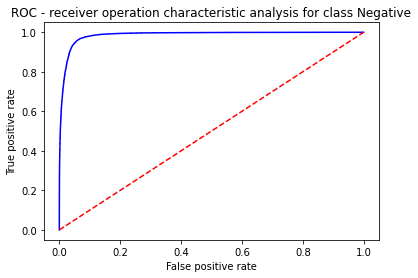

AUC score class Positive : 0.9857116804988453


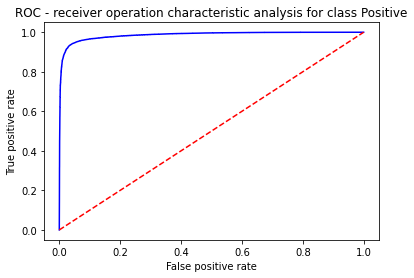

              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95     23916
    Positive       0.96      0.94      0.95     24001

    accuracy                           0.95     47917
   macro avg       0.95      0.95      0.95     47917
weighted avg       0.95      0.95      0.95     47917



,Negative,Positive
Negative,22949,967
Positive,1443,22558


In [9]:
y_pred_, y_true_, probs_, target_names_ = get_analytic_features(model_mgr=sentiment_polarity_mgr)
model_classification_report_, model_confusion_matrix_df_ = get_classification_analysis(y_true_, y_pred_, target_names_)
auc_analysis(probs=probs_, label_mgr=sentiment_polarity_mgr.model_label_mgr, target_names=target_names_, y_true=y_true_)
del sentiment_polarity_mgr
print(model_classification_report_)
model_confusion_matrix_df_